# MODFLOW API Paper

# Create Trimesh Grid for McDonald Valley Problem for the "Optimization of groundwater withdrawals" example

This notebook can be used to create the MODFLOW 6 datasets used by the "Optimization of groundwater withdrawals" example, as reported in the MODFLOW 6 API paper (in progress). This notebook should be run prior to running the `optimize_mv_api.ipynb` notebook.

## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __libmf6.dll__ (Windows) or __libmf6.so__ (linux or MacOS) pre-compiled dynamic-link library (dll)/shared object (so) and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled dll/so should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __mf6.exe__ (Windows) or __mf6__ (linux or MacOS) pre-compiled application and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled application should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
https://github.com/Deltares/xmipy.
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.
    
## Building the McDonald Valley MODFLOW 6 datasets

We start by importing the necessary packages:

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import flopy
from flopy.utils.gridgen import Gridgen
import flopy.plot.styles as styles

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
numpy version: 1.20.3
matplotlib version: 3.4.2
flopy version: 3.3.5


In [2]:
if sys.platform == "win32":
    exe_name = os.path.abspath('../bin/mf6.exe')
else:
    exe_name = os.path.abspath('../bin/mf6')

## Load External Data

In [3]:
# Load ESRI ascii grids of hydraulic properties and bottom
# elevation from a 40 by 25 regular grid
kaq = flopy.utils.Raster.load("./data/k_aq.asc")
kclay = flopy.utils.Raster.load("./data/k_clay.asc")
bot = flopy.utils.Raster.load("./data/bottom.asc")

## Create Structured Grid

In [4]:
nlay = 5
nrow = 40
ncol = 25
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)
delr, delc = 500., 500.
delrs = np.ones(ncol, dtype=np.float32) * delr
delcs = np.ones(nrow, dtype=np.float32) * delc
top = np.ones(shape2d, dtype=np.float32) * 100.
botm = np.zeros(shape3d, dtype=np.float32)
botm[0] = -5.0
botm[1] = -50.0
botm[2] = -51.0
botm[3] = -100.0
botm[4] = bot.get_array(1)

struct_grid = flopy.discretization.StructuredGrid(
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=delrs,
    delc=delcs,
)

## Read the Trimesh File into Python

In [5]:
fname = './data/TriMesh_with_densified_contours.exp'
with open(fname, 'r') as f:
    lines = f.readlines()

# read vertex info into a structured array
vtmp = [line.strip().split()[1:] for line in lines if line.startswith('N')]
dtype = [('ivert', int), ('x', float), ('y', float), ('label', '|S10'), ('ibound', int), ('elev', float)]
vertices = np.empty((len(vtmp)), dtype=dtype)
for i, line in enumerate(vtmp):
    for j, val in enumerate(line):
        vertices[i][j] = val

# read element info into a structured array
etmp = [line.strip().split()[1:] for line in lines if line.startswith('E')]
dtype = [('icell', int), ('iv1', int), ('iv2', int), ('iv3', int), ('label', '|S10'), ('ibound', int), ('elev', float)]
cells = np.empty((len(etmp)), dtype=dtype)
for i, line in enumerate(etmp):
    for j, val in enumerate(line):
        cells[i][j] = val

In [6]:
verts = []
for ivert, x, y, label, ibound, elev in vertices:
    verts.append([x, y])
verts = np.array(verts, dtype=float)
    
iverts = []
for i, iv1, iv2, iv3, s, ibound, elev in list(cells):
    iverts.append([iv3 - 1, iv2 - 1, iv1 - 1])
    
ncpl = len(iverts)
nvert = verts.shape[0]

## Calculate Centroids

In [7]:
# centroid and area array
from flopy.utils.cvfdutil import centroid_of_polygon, area_of_polygon
xcyc = np.empty((ncpl, 2), dtype=float)
area = np.empty((ncpl), dtype=float)
for icell in range(ncpl):
    vlist = [(verts[ivert, 0], verts[ivert, 1]) for ivert in iverts[icell]]
    xcyc[icell, 0], xcyc[icell, 1] = centroid_of_polygon(vlist)
    area[icell] = abs(area_of_polygon(*zip(*vlist)))

In [8]:
# make temporary vertex grid for plotting and intersecting
vertices = []
for i in range(nvert):
    vertices.append((i, verts[i, 0], verts[i, 1]))

cell2d = []
for i in range(ncpl):
    cell2d.append([i, xcyc[i, 0], xcyc[i, 1], 3] + [iv for iv in iverts[i]])    

vg_temp = flopy.discretization.VertexGrid(vertices=vertices, cell2d=cell2d, 
                                          nlay=1, ncpl=len(cell2d))

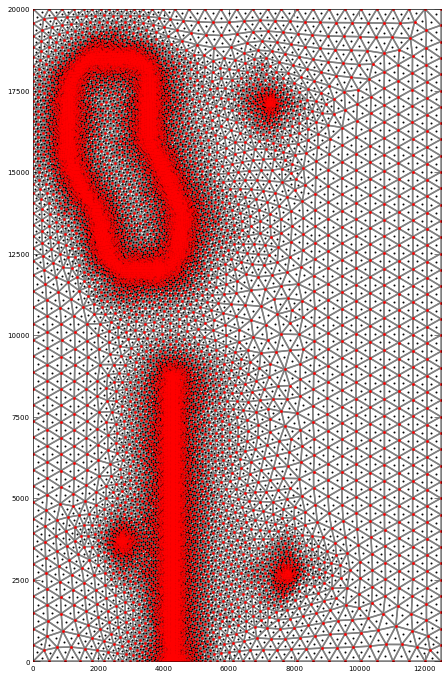

In [9]:
# plot the triangular grid
grid_verts = vg_temp.verts
xcc, ycc = vg_temp.xyzcellcenters[:2]

with styles.USGSMap():
    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp)
    mm.plot_grid()
    plt.plot(xcc, ycc, 'ko', markersize=1.)
    plt.plot(grid_verts[:,0], grid_verts[:,1], 'rs', markersize=1.5)

## Intersect the Grid with the Property Arrays

In [10]:
kaq_tm = kaq.resample_to_grid(vg_temp,
                              band=kaq.bands[0],
                              method="nearest")
kclay_tm = kclay.resample_to_grid(vg_temp,
                                  band=kclay.bands[0],
                                  method="nearest")
bot_tm = bot.resample_to_grid(vg_temp,
                              band=bot.bands[0],
                              method="nearest")

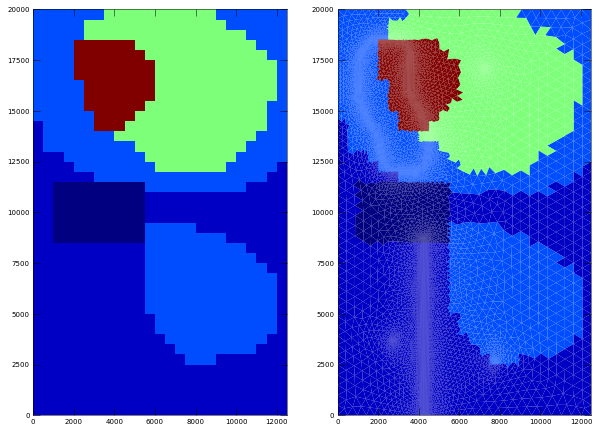

In [11]:
# plot K aquifer
with styles.USGSMap():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kaq.get_array(1), cmap='jet')

    ax = fig.add_subplot(1, 2, 2, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(kaq_tm, cmap='jet')
    plt.xlim(verts[:, 0].min(), verts[:, 0].max())
    plt.ylim(verts[:, 1].min(), verts[:, 1].max())

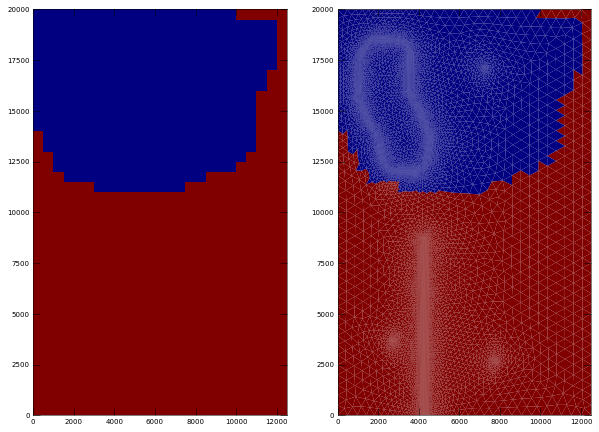

In [12]:
# plot K clay
with styles.USGSMap():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kclay.get_array(1), cmap='jet')

    ax = fig.add_subplot(1, 2, 2, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(kclay_tm, cmap='jet')
    plt.xlim(verts[:, 0].min(), verts[:, 0].max())
    plt.ylim(verts[:, 1].min(), verts[:, 1].max())

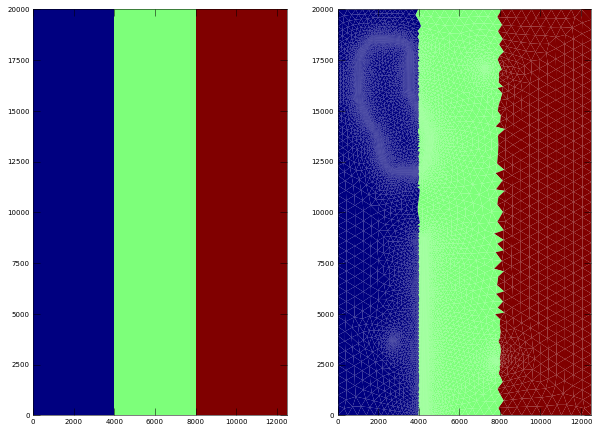

In [13]:
# plot bottom elevation
with styles.USGSMap():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(bot.get_array(1), cmap='jet')

    ax = fig.add_subplot(1, 2, 2, aspect='equal')
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(bot_tm, cmap='jet')
    plt.xlim(verts[:, 0].min(), verts[:, 0].max())
    plt.ylim(verts[:, 1].min(), verts[:, 1].max())

## Intersect the Features with the Grid

(0.0, 20000.0)

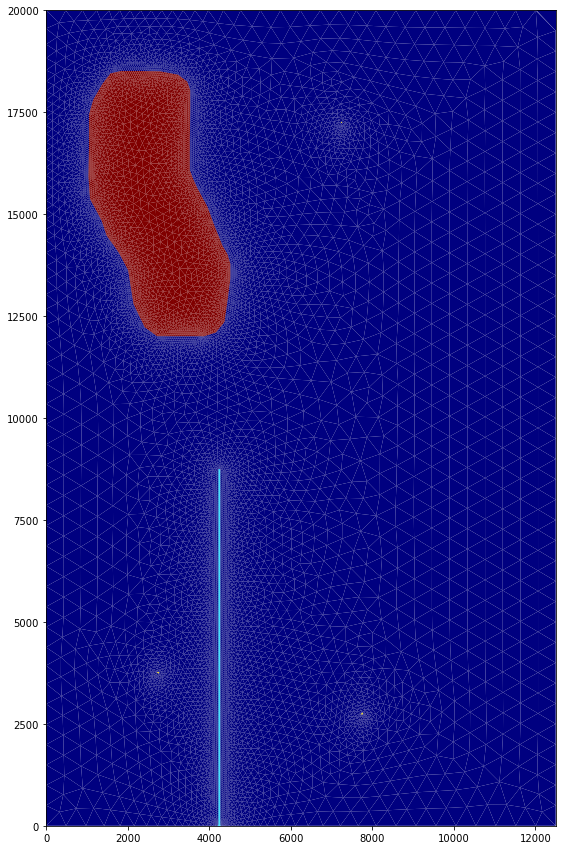

In [14]:
ibd = cells['ibound']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(modelgrid=vg_temp)
mm.plot_array(ibd, cmap='jet')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

In [15]:
iriv = 1
iwel = 2
ilak = 3

idx = cells['ibound'] == iriv

rbot = -2.
ct = 0.
at = 0.

# cond_scale is needed to make sure the total conductance
# is similar to what is in the regular grid.
cond_scale = 10.28
rivspd = []
for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]:
    icell = ip1 - 1
    distance = xcyc[icell, 1]
    stage = 0. + distance / (18 * delc)
    cond = 1.e5
    cond = cond / (delc * delr) * area[icell]
    cond = cond * cond_scale
    ct += cond
    at += area[icell]
    rivspd.append([(0, icell), stage, cond, rbot])

In [16]:
iriv = 1
iwel = 2
ilak = 3
idx = cells['ibound'] == ilak
chdspd = [[(0, ip1 - 1), 11.] for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]]

In [17]:
# first well is Virginia City well site 2
# second well is Reilly well
# third well is Virginia City well site 1
idx = cells['ibound'] == iwel
boundname = ['VC2', 'Reilly', 'VC1']
welspd = [[(4, ip1 - 1), 0.] for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]]
welspd = [[cellid, rate, boundname[i]] for i, (cellid, rate) in enumerate(welspd)]
welspd

[[(4, 14900), 0.0, 'VC2'],
 [(4, 19667), 0.0, 'Reilly'],
 [(4, 20131), 0.0, 'VC1']]

## Build the Model

In [18]:
ws = './mvmodel'
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name=exe_name)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=5, ncpl=ncpl, nvert=nvert, 
                               top=cells['elev'],
                               botm=[-5, -50, -51, -100., bot_tm],
                               vertices=vertices, cell2d=cell2d)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              xt3doptions=True, save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq_tm, kaq_tm, kclay_tm, kaq_tm, kaq_tm],
                              k33=[0.25 * kaq_tm, 0.25 * kaq_tm, kclay_tm, 0.25 * kaq_tm, 0.25 * kaq_tm])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welspd, boundnames=True)
oc = flopy.mf6.ModflowGwfoc(gwf, 
                            head_filerecord=name + '.hds', 
                            budget_filerecord=name + '.bud',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mv...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 4590 based on size of stress_period_data
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 728 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /Users/langevin/langevin/doc/bmi-paper/mf6bmipaper.git/models/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07

(True, [])

## Post-Process the Results

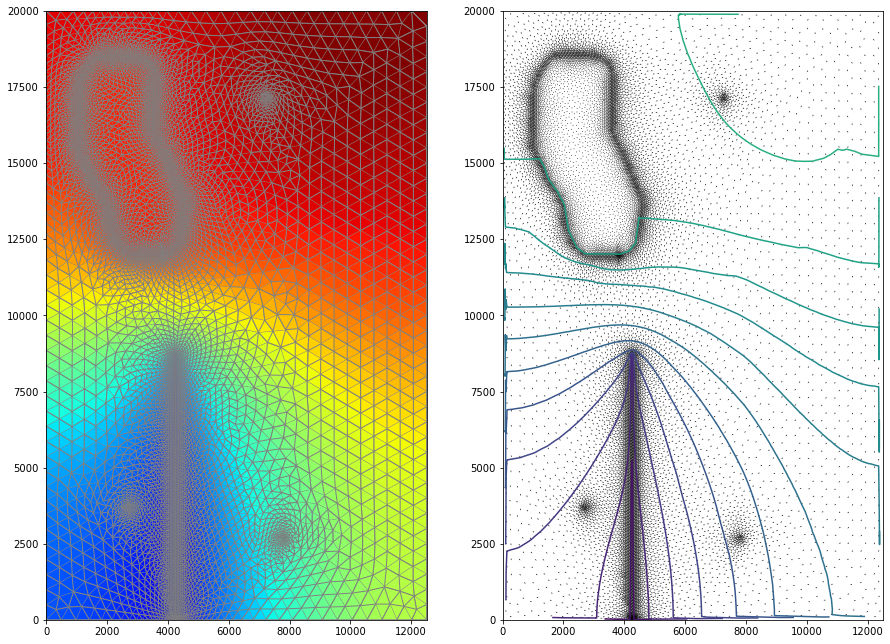

In [19]:
from flopy.utils.binaryfile import HeadFile, CellBudgetFile
fname = os.path.join(ws, name + '.hds')
headobj = HeadFile(fname)
head = headobj.get_data()[:, 0, :]
fname = os.path.join(ws, name + '.bud')
budobj = CellBudgetFile(fname, precision='double')
spdis = budobj.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

ilay = 0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.plot_array(head, cmap='jet', ec='gray')

ax = fig.add_subplot(1, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.contour_array(head, levels=np.arange(20))
pmv.plot_vector(qx, qy, normalize=True)

# Figure for Paper

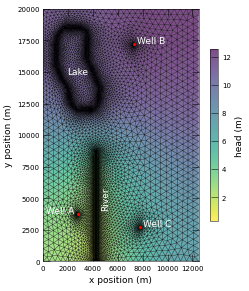

In [20]:
# configure settings
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7

figwidth = 85 # mm
figwidth = figwidth / 10 / 2.54 # inches

figheight = 100 # mm
figheight = figheight / 10 / 2.54 # inches

with styles.USGSMap():

    fig = plt.figure(
        figsize=(figwidth, figheight),
        constrained_layout=True,
    )
    ax = fig.add_subplot(1, 1, 1)
    # ax.set_aspect('equal')
    pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)

    pa = pmv.plot_array(head, cmap='viridis_r', ec='none', alpha=0.7)
    pmv.plot_grid(linewidths=0.2, colors='black')

    iplot = np.ones(cells['ibound'].shape, dtype=int)
    idx = cells['ibound'] == iriv
    iplot[idx] = -1
    pmv.plot_ibound(iplot, color_ch='cyan')

    wellnames = ['A', 'B', 'C']
    idx = cells['ibound'] == iwel
    for idx, icell in enumerate(cells['icell'][idx]):
        x, y = xcyc[icell]
        ax.plot(x, y, 'ro', markersize=2)
        s = wellnames.pop(0)
        s = "Well {}".format(s)
        if idx == 0:
            xx = x - 250
            ha = "right"
        else:
            xx = x + 250
            ha = "left"
        styles.add_text(
            ax, 
            text=s, 
            x=xx, 
            y=y+250, 
            color='white', 
            transform=False, 
            bold=False, 
            italic=False,
            va="center", 
            ha=ha,
        )    

    styles.add_text(
        ax, 
        text="Lake", 
        x=2750, 
        y=15000, 
        color='white', 
        transform=False, 
        bold=False, 
        italic=False,
        va="center", 
        ha="center",
    )
    styles.add_text(
        ax, 
        text="River", 
        x=5000, 
        y=5000, 
        color='white', 
        transform=False, 
        bold=False, 
        italic=False,
        va="center", 
        ha="center",
        rotation="vertical",
    )

    ax.set_xlabel('x position (m)')
    ax.set_ylabel('y position (m)')
    cbar = fig.colorbar(pa, shrink=0.68)
    cbar.ax.set_ylabel('head (m)')

    fpth = os.path.join('..', '..', 'doc', 'figures')
    fname = 'mf6opt.png'
    if os.path.isdir(fpth):
        fname = os.path.join(fpth, fname)
    plt.savefig(fname, dpi=600)